# 쓰레기 이미지 분류



In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pwd
!ls

/content
sample_data


In [3]:
# 실행시 등장하는 URL을 클릭하여 허용해주면 인증KEY가 나타난다. 복사하여 URL아래 빈칸에 붙여넣으면 마운트에 성공하게된다.
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
# 해당 드라이브로 이동 
# 내 드라이브는 원격서버가 아니라 로컬서버로 간주하므로 명령어 실행시 앞단에 !를 붙이지 않는다.
!pwd
import os
os.chdir('/content/gdrive/MyDrive/')
!pwd

/content
/content/gdrive/MyDrive


In [5]:
cd /content/gdrive/MyDrive/Dataset

/content/gdrive/MyDrive/Dataset


In [6]:
pwd

'/content/gdrive/MyDrive/Dataset'

In [7]:
dir  = '/content/gdrive/MyDrive/Dataset/Garbage classification/Garbage classification'

classes = os.listdir(dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## 데이터 전처리

In [ ]:
transformations = transforms.Compose([transforms.Resize((256, 256)), 
                                      transforms.ToTensor()
                                      ])

dataset = ImageFolder(dir, transform = transformations)

dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /content/gdrive/MyDrive/Dataset/Garbage classification/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

## 데이터 분리하기
### train_ds / val_ds / test_ds

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [1618, 404, 505])
len(train_ds), len(val_ds), len(test_ds)

(1618, 404, 505)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class TrainerBase(nn.Module):   
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # predictions
        loss = F.cross_entropy(out, labels)   # loss
        acc = accuracy(out, labels)           # accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print('Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']
        ))

In [ ]:
class ResNet(TrainerBase):
    def __init__(self):
        super().__init__()      
        # pretrained model
        self.network = models.resnet50(pretrained=True)     
    
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

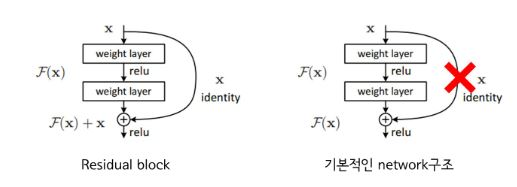

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## Evaluation

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        # Training 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation 
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """ return number of batch size """
        return len(self.dl)

In [ ]:
model = ResNet().to(device)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

print(model)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.12991072237491608, 'val_loss': 1.7901121377944946}

Train

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.4682, val_loss: 1.2645, val_acc: 0.8330
Epoch [1], train_loss: 1.1762, val_loss: 1.1944, val_acc: 0.8692
Epoch [2], train_loss: 1.1016, val_loss: 1.1497, val_acc: 0.9031
Epoch [3], train_loss: 1.0758, val_loss: 1.1300, val_acc: 0.9308
Epoch [4], train_loss: 1.0646, val_loss: 1.1390, val_acc: 0.9237
Epoch [5], train_loss: 1.0570, val_loss: 1.1278, val_acc: 0.9304
Epoch [6], train_loss: 1.0556, val_loss: 1.1312, val_acc: 0.9281
Epoch [7], train_loss: 1.0542, val_loss: 1.1308, val_acc: 0.9121
Epoch [8], train_loss: 1.0513, val_loss: 1.1290, val_acc: 0.9147
Epoch [9], train_loss: 1.0515, val_loss: 1.1389, val_acc: 0.8987


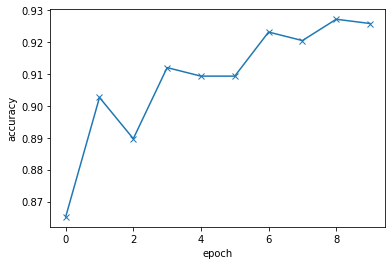

In [ ]:
def plot_1(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

plot_1(history)

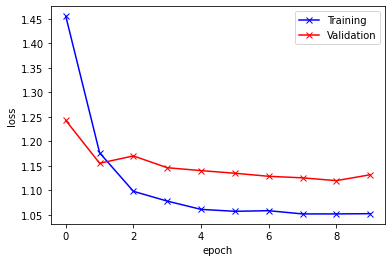

In [ ]:
def plot_2(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])

plot_2(history)

## Predict
### 테스트 데이터(test_ds)  예측 

In [ ]:
def predict(img, model):

    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    prob, preds  = torch.max(yb, dim=1)

    return dataset.classes[preds[0].item()]

Label: glass , Predict: glass


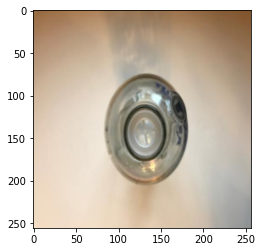

In [ ]:
img, label = test_ds[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predict:', predict(img, model))

Label: paper , Predict: paper


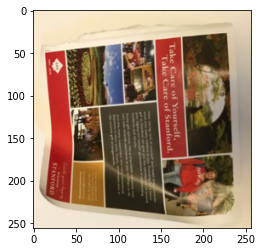

In [ ]:
img, label = test_ds[504]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predict:', predict(img, model))

Label: cardboard , Predict: cardboard


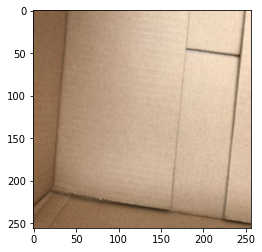

In [ ]:
img, label = test_ds[5]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predict:', predict(img, model))

Label: plastic , Predict: plastic


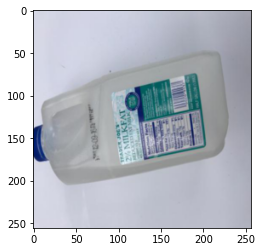

In [ ]:
img, label = test_ds[39]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predict:', predict(img, model))

Label: trash , Predict: trash


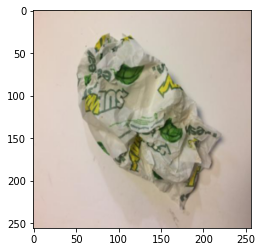

In [ ]:
img, label = test_ds[390]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predict:', predict(img, model))

Label: metal , Predict: metal


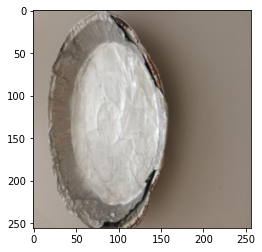

In [ ]:
img, label = test_ds[50]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predict:', predict(img, model))

Label: glass , Predict: glass


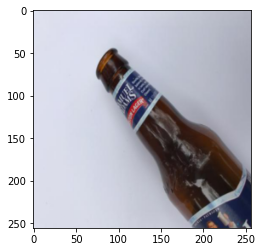

In [ ]:
img, label = test_ds[500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predict:', predict(img, model))

# 결과

In [ ]:
cd /content/gdrive/MyDrive/Dataset

/content/gdrive/MyDrive/Dataset


In [ ]:
ls

 1.JPG                      metal.JPG
 2.JPG                      networks/
 3.JPG                      one-indexed-files-notrash_test.txt
 4.JPG                      one-indexed-files-notrash_train.txt
 5.JPG                      one-indexed-files-notrash_val.txt
 6.JPG                      one-indexed-files.txt
 archive.zip                paper.JPG
 cardboard.JPG              trainers/
 dogs-vs-cats/              utils/
'garbage classification'/   video1.mp4
'Garbage classification'/   zero-indexed-files.txt
 __init__.py


Predict:  cardboard.


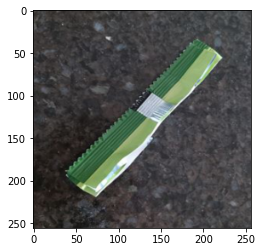

In [ ]:
from PIL import Image

image = Image.open('1.JPG')
example_image = transformations(image)
plt.imshow(example_image.permute(1, 2, 0))
print("Predict: ", predict(example_image, model) + ".")

Predict:  plastic.


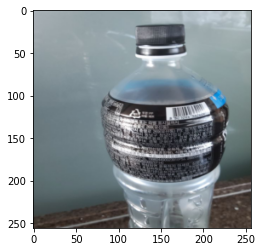

In [ ]:
image = Image.open('2.JPG')
example_image = transformations(image)
plt.imshow(example_image.permute(1, 2, 0))
print("Predict: ", predict(example_image, model) + ".")

Predict:  cardboard.


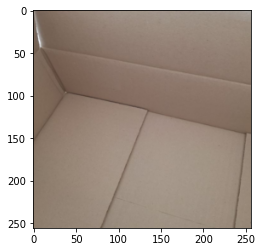

In [ ]:
image = Image.open('3.JPG')
example_image = transformations(image)
plt.imshow(example_image.permute(1, 2, 0))
print("Predict: ", predict(example_image, model) + ".")

Predict:  metal.


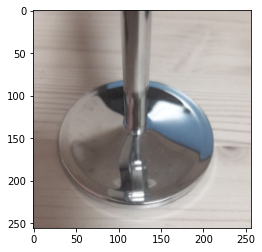

In [ ]:
image = Image.open('4.JPG')
example_image = transformations(image)
plt.imshow(example_image.permute(1, 2, 0))
print("Predict: ", predict(example_image, model) + ".")

Predict:  trash.


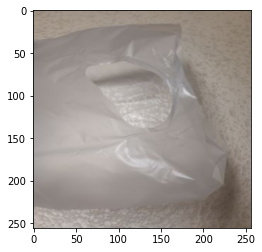

In [ ]:
image = Image.open('5.JPG')
example_image = transformations(image)
plt.imshow(example_image.permute(1, 2, 0))
print("Predict: ", predict(example_image, model) + ".")

Predict:  paper.


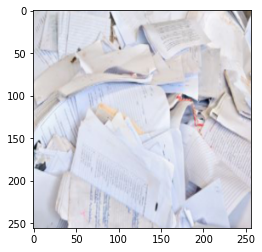

In [ ]:
image = Image.open('paper.JPG')
example_image = transformations(image)
plt.imshow(example_image.permute(1, 2, 0))
print("Predict: ", predict(example_image, model) + ".")

Predict:  cardboard.


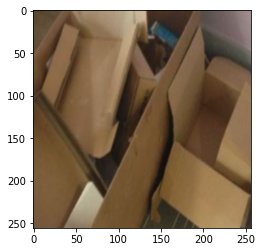

In [ ]:
image = Image.open('cardboard.JPG')
example_image = transformations(image)
plt.imshow(example_image.permute(1, 2, 0))
print("Predict: ", predict(example_image, model) + ".")

Predict:  metal.


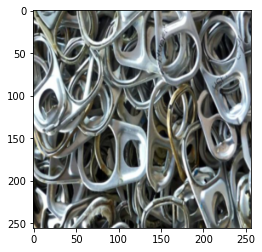

In [ ]:
image = Image.open('metal.JPG')
example_image = transformations(image)
plt.imshow(example_image.permute(1, 2, 0))
print("Predict: ", predict(example_image, model) + ".")

Predict:  glass.


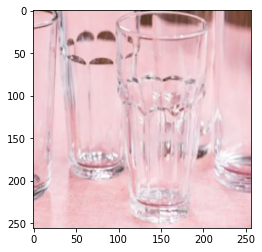

In [ ]:
image = Image.open('8.JPG')
example_image = transformations(image)
plt.imshow(example_image.permute(1, 2, 0))
print("Predict: ", predict(example_image, model) + ".")

Predict:  paper.


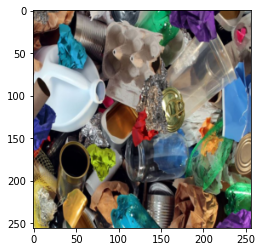

In [ ]:
image = Image.open('6.JPG')
example_image = transformations(image)
plt.imshow(example_image.permute(1, 2, 0))
print("Predict: ", predict(example_image, model) + ".")